---
## Bibliotecas

In [17]:
import pandas as pd
pd.set_option('display.max_rows', 1000)  

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm

from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

from sklearn.datasets import load_breast_cancer

from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings('ignore')

---
### Modelos e Partições:

In [18]:
# Dataset
data = load_breast_cancer()
X, y = data.data, data.target  # y = 0 (Maligno), y = 1 (Benigno)

# Classificadores
classifiers = {
    "Random Forest": RandomForestClassifier(n_estimators = 100, random_state = 42),
    "SVM (RBF)": SVC(C = 10, gamma = 0.01, kernel = 'rbf', class_weight = 'balanced', random_state = 42),
    "XGBoost": XGBClassifier(n_estimators = 100, objective = 'binary:logistic', tree_method = 'hist', eta = 0.1, 
                             max_depth = 3, enable_categorical = True, random_state = 42),
    "MLP": MLPClassifier(solver = 'sgd', alpha = 1e-5, # solver='lbfgs', alpha=1e-5,
                         hidden_layer_sizes = (128, 128, 128),max_iter = 2000, random_state = 42)
}

# Partições (k = 10)
cv = StratifiedKFold(n_splits = 10, shuffle = True, random_state = 42)

In [19]:
df = pd.DataFrame(data.data, columns=data.feature_names)
df["target"] = data.target

In [20]:
df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


### Loop principal
- Adciona ruido nos labels '1'

In [21]:
all_results = []

# Ruidos
noise_levels = [0, 0.005, 0.01, 0.015, 0.02, 0.025, 0.03, 0.035, 0.04]

# Loop para cada nível de ruído
for noise_level in tqdm(noise_levels):
    # Criar uma cópia das labels para inserir ruído
    y_noisy = y.copy()
    
    # Filtrar apenas as amostras "Benigno" (1)
    #benign_indices = np.where(y_noisy == 1)[0]

    # Filtrar apenas as amostras "Benigno" (0)
    benign_indices = np.where(y_noisy == 0)[0]
    
    # Definir a quantidade de labels a serem invertidas
    num_samples = int(noise_level * len(benign_indices))
    
    # Selecionar aleatoriamente os índices para trocar de Benigno (1) para Maligno (0)
    selected_indices = np.random.choice(benign_indices, num_samples, replace=False)
    #y_noisy[selected_indices] = 0  # Troca 'Benigno (1)' para 'Maligno (0)'
    y_noisy[selected_indices] = 1  # Troca 'Benigno (0)' para 'Maligno (1)'
    
    for name, model in classifiers.items():
        fold = 1
        for train_idx, test_idx in cv.split(X, y):
            X_train, X_test = X[train_idx], X[test_idx]
            y_train, y_test = y_noisy[train_idx], y[test_idx]  # Treina com rótulos ruidosos, mas avalia com os corretos  
            model.fit(X_train, y_train)         
            y_pred = model.predict(X_test)
            acc = accuracy_score(y[test_idx], y_pred)  # Comparando com labels reais
            
            for true_label, pred_label in zip(y[test_idx], y_pred):
                all_results.append([noise_level, name, fold, true_label, pred_label, acc])
            
            fold += 1

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:43<00:00,  4.80s/it]


In [22]:
# Criar DataFrame com os resultados
df_results = pd.DataFrame(all_results, columns=["Noise Level", "Classifier", "Fold", "True Label", "Predicted Label", "Accuracy"])

df_results.to_csv("resultados/Piloto4/results_completo.csv")

In [10]:
df_results.head()

,Noise Level,Classifier,Fold,True Label,Predicted Label,Accuracy
0,0.0,Random Forest,1,0,0,0.947368
1,0.0,Random Forest,1,0,0,0.947368
2,0.0,Random Forest,1,0,0,0.947368
3,0.0,Random Forest,1,0,0,0.947368
4,0.0,Random Forest,1,1,1,0.947368


In [11]:
df_results.shape

(20484, 6)

---
### Carrega dados:

In [12]:
df_results = pd.read_csv("resultados/Piloto3/results_completo.csv", index_col = 0)

In [13]:
df_results.head()

,Noise Level,Classifier,Fold,True Label,Predicted Label,Accuracy
0,0.0,Random Forest,1,0,0,0.947368
1,0.0,Random Forest,1,0,0,0.947368
2,0.0,Random Forest,1,0,0,0.947368
3,0.0,Random Forest,1,0,0,0.947368
4,0.0,Random Forest,1,1,1,0.947368


In [14]:
def plot_confusion_matrices_grid(model_name, noise_levels = None, percent = False, grid_type = "folds"):
    """
    Gera um grid de matrizes de confusão.
    
    Opções:
    - grid_type = "folds" → Gera um grid com todos os folds de um único nível de ruído.
    - grid_type = "noise" → Gera um grid com o melhor fold (maior acurácia) de cada nível de ruído.

    Argumentos:
    - model_name (str): Nome do classificador.
    - noise_levels (list): Lista de níveis de ruído a serem analisados (necessário se grid_type="noise").
    - percent (bool): Se True, exibe as matrizes como porcentagens.
    - grid_type (str): "folds" para mostrar todos os folds de um ruído, "noise" para mostrar só o melhor fold de cada ruído.
    """

    if grid_type == "folds":
        if not noise_levels or len(noise_levels) != 1:
            raise ValueError("Para grid_type='folds', forneça um único nível de ruído em noise_levels.")

        noise_level = noise_levels[0] 
        df_filtered = df_results[(df_results["Classifier"] == model_name) & 
                                 (df_results["Noise Level"] == noise_level)]

        folds = df_filtered["Fold"].unique()
        num_folds = len(folds)

        rows, cols = 2, 5
        fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(15, 6))
        axes = axes.flatten()

        for i, fold in enumerate(folds):
            df_fold = df_filtered[df_filtered["Fold"] == fold]
            y_true = df_fold["True Label"]
            y_pred = df_fold["Predicted Label"]
            cm = confusion_matrix(y_true, y_pred)

            if percent:
                cm = cm.astype('float') / cm.sum(axis=1, keepdims=True)
                fmt = ".2%"
            else:
                fmt = "d"

            sns.heatmap(cm, annot=True, fmt=fmt, cmap="Blues",
                        xticklabels=["Maligno", "Benigno"], 
                        yticklabels=["Maligno", "Benigno"], 
                        ax=axes[i])
            axes[i].set_title(f"Fold {fold}")
            axes[i].set_xlabel("Predito")
            axes[i].set_ylabel("Real")

        for j in range(i+1, len(axes)):
            fig.delaxes(axes[j])

        plt.suptitle(f"Matrizes de Confusão para {model_name} - Ruído {noise_level*100:.0f}%", fontsize=14)
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()

    elif grid_type == "noise":
        if not noise_levels:
            raise ValueError("Forneça uma lista de níveis de ruído!")

        rows, cols = 2, max(1, int(np.ceil(len(noise_levels)/2)))
        fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(15, 6))
        axes = axes.flatten()

        for i, noise_level in enumerate(noise_levels):
            df_filtered = df_results[(df_results["Classifier"] == model_name) & 
                                     (df_results["Noise Level"] == noise_level)]
            
            if df_filtered.empty:
                continue

            # Selecionar o fold com maior acurácia
            best_fold = df_filtered.groupby("Fold")["Accuracy"].mean().idxmax()
            df_best_fold = df_filtered[df_filtered["Fold"] == best_fold]
            y_true = df_best_fold["True Label"]
            y_pred = df_best_fold["Predicted Label"]
            cm = confusion_matrix(y_true, y_pred)

            if percent:
                cm = cm.astype('float') / cm.sum(axis=1, keepdims=True)
                fmt = ".2%"
            else:
                fmt = "d"

            sns.heatmap(cm, annot=True, fmt=fmt, cmap="Blues",
                        xticklabels=["Maligno", "Benigno"], 
                        yticklabels=["Maligno", "Benigno"], 
                        ax=axes[i])
            axes[i].set_title(f"Ruído {noise_level*100:.00f}% - Fold {best_fold}")
            axes[i].set_xlabel("Predito")
            axes[i].set_ylabel("Real")

        for j in range(i+1, len(axes)):
            fig.delaxes(axes[j])

        plt.suptitle(f"Matriz de Confusão - Modelo: {model_name} - Melhor partição por Nível de Ruído", fontsize=14)
        plt.tight_layout(rect=[0, 0, 1, 0.95])
        plt.show()

    else:
        raise ValueError("grid_type deve ser 'folds' ou 'noise'.")

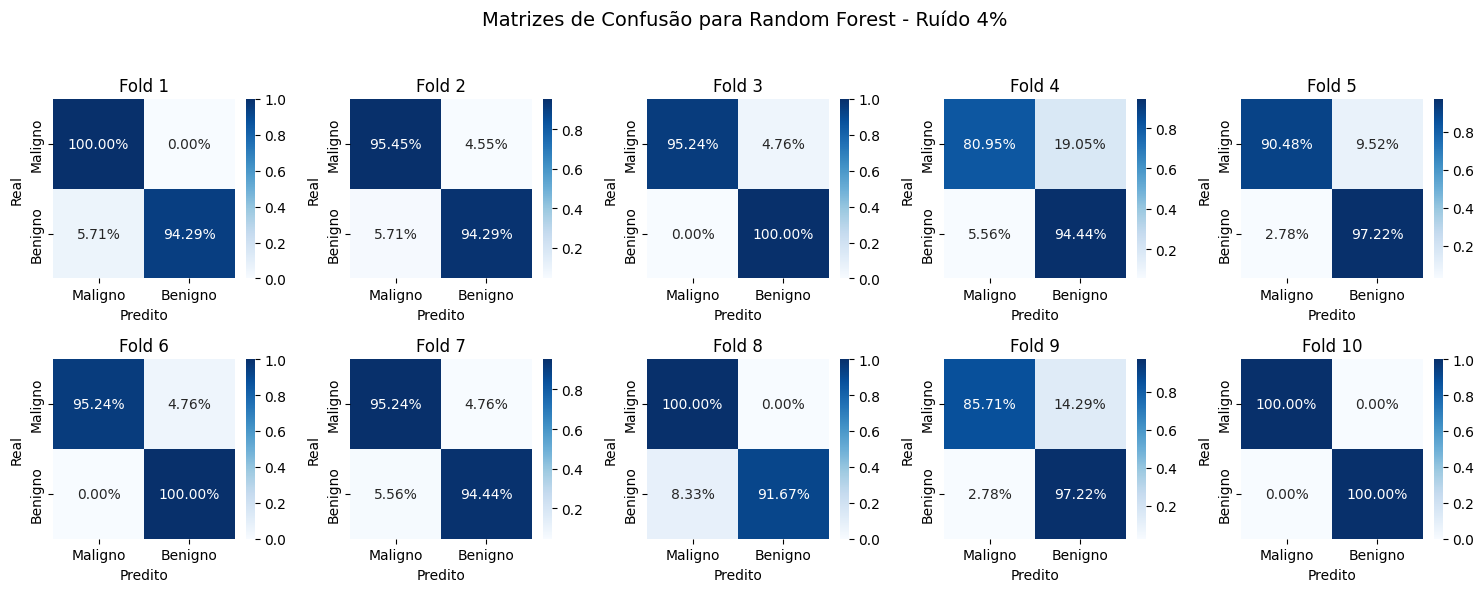

In [15]:
plot_confusion_matrices_grid("Random Forest", noise_levels=[0.04], percent=True, grid_type="folds")

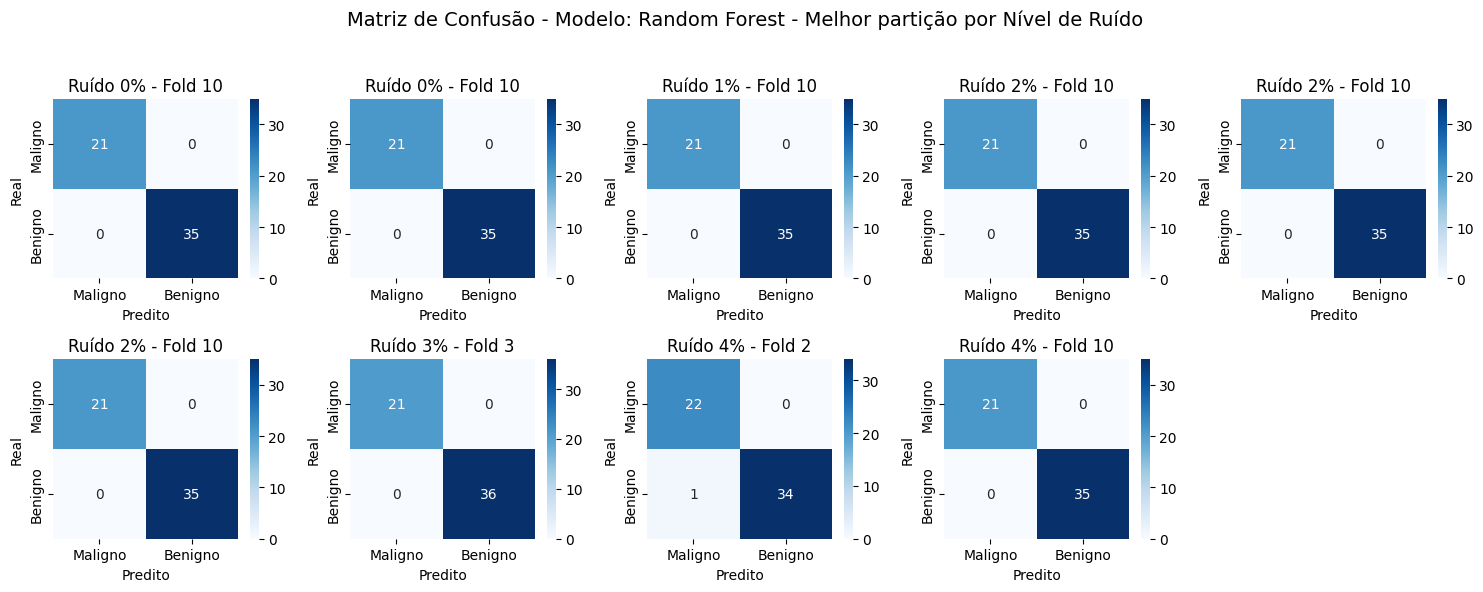

In [16]:
# Mostrar apenas o melhor fold para cada nível de ruído
plot_confusion_matrices_grid("Random Forest", noise_levels=noise_levels, percent=False, grid_type="noise")